# Imports and function definitions (RUN ME!)

In [1]:
# !pip install opencv-python

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [4]:
!ls "/content/drive/My Drive/DL"

ls: cannot access '/content/drive/My Drive/DL': No such file or directory


In [ ]:
# Defining paths to files
persistence_path = "/content/drive/My Drive/DL/" # TODO: replace me
working_directory = "/content/" # TODO: replace me (or not)

# Image only
zip_image_only_path = persistence_path + 'summed_diff_images.zip'
unzip_image_only_path = working_directory + 'image_only/'

# Image + GAF
zip_gaf_sd_path = persistence_path + 'fused_gaf_sd.zip'
unzip_gaf_sd_path = working_directory + 'fused_gaf_sd/'

# Image + RP (ankle acc, ankle gyro)
fused_images_zip_path = persistence_path + 'fused_images_rp_summed_diff.zip'
unzip_fused_images_path = working_directory + 'fused_images/'

# Image + RP (ankle acc, ankle gyro, wrist acc, wrist gyro)
zip_rp_sd_ankle_wrist_path = persistence_path + 'fused_images_rp_sd_ankle_wrist.zip'
unzip_rp_sd_ankle_wrist_path = working_directory + 'fused_images_rp_sd_ankle_wrist/'

In [ ]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check GPU availability
gpus_no = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", gpus_no)
# assert gpus_no >= 1, "You're not using a GPU, are you sure you want to proceed?"

Num GPUs Available:  0


In [ ]:
def load_data_from_path(trial_path):
    """
    Function that supports loading both images and already processed fused data
    merged of load_data_from_trial and load_fused_data
    """
    data = []
    labels = []
    skipped_files = []

    for root, _, files in os.walk(trial_path):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                # NOTE: moved this here because idk if file naming strategy is different between plain images and fused
                # it was in the loop above before refactor..
                # Extract activity label from the folder name
                try:
                    folder_name = os.path.basename(root)
                    activity_label = int([part for part in folder_name.split('_') if "Activity" in part][0].replace('Activity', '')) - 1
                except (IndexError, ValueError) as e:
                    skipped_files.append((root, str(e)))
                    continue

                try:
                    # Load the image and normalize to [0, 1]
                    image = plt.imread(file_path) / 255.0
                    data.append(image)
                    labels.append(activity_label)
                except Exception as e:
                    skipped_files.append((file_path, str(e)))

            # NOTE: the part from load_fused is here
            elif file.endswith('.npy'):
                file_path = os.path.join(root, file)
                fused_image = np.load(file_path)

                # Extract activity label from the parent folder structure
                try:
                    folder_name = os.path.basename(root)  # Example: Subject10_Activity10_Trial1
                    activity_part = folder_name.split("_")[1]  # Extracts 'Activity10'
                    activity_label = int(activity_part.replace('Activity', '')) - 1  # Convert to 0-based indexing

                    data.append(fused_image)
                    labels.append(activity_label)
                except (IndexError, ValueError) as e:
                    skipped_files.append((file_path, str(e)))

    # Log skipped files
    if skipped_files:
        print(f"Skipped {len(skipped_files)} files or folders due to errors:")
        for file_path, error in skipped_files[:10]:  # Limit output for clarity
            print(f"File or Folder: {file_path}, Error: {error}")

    return np.array(data), np.array(labels)


def split_train_val_test_from_trials(trial1_path, trial2_path, trial3_path):
    """
    In the dataset, each subject makes three trials of the same activity,

    We use the third trial as test,
    and the first and second trials are merged and then randomly split into train and test sets
    """
    X_trial1, y_trial1 = load_data_from_path(trial1_path)
    X_trial2, y_trial2 = load_data_from_path(trial2_path)
    X_trial3, y_trial3 = load_data_from_path(trial3_path)

    # Combine trial1 and trial2 for training and validation
    X_train_val = np.concatenate((X_trial1, X_trial2), axis=0)
    y_train_val = np.concatenate((y_trial1, y_trial2), axis=0)

    # Use trial3 as the test set
    X_test, y_test = X_trial3, y_trial3

    # Split training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Print data shapes
    print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
    print("Validation data shape:", X_val.shape, "Validation labels shape:", y_val.shape)
    print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def unzip(zip_path, output_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

# Defining models

In [ ]:
# Define the CNN model. NOTE: The same model is used in all experiments
def create_model(input_shape, num_classes, image_only_flag=None):

    if image_only_flag: # bear with me
      input_shape=(input_shape[0], input_shape[1], 1)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Only image data training

In [ ]:
unzip(zip_image_only_path, unzip_image_only_path)

In [ ]:
# Paths to individual trial folders
trial1_path = os.path.join(unzip_image_only_path, 'trial1_summed_diff_images')
trial2_path = os.path.join(unzip_image_only_path, 'trial2_summed_diff_images')
trial3_path = os.path.join(unzip_image_only_path, 'trial3_summed_diff_images')

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test_from_trials(trial1_path, trial2_path, trial3_path)

Training data shape: (3100, 32, 32) Training labels shape: (3100,)
Validation data shape: (776, 32, 32) Validation labels shape: (776,)
Test data shape: (1931, 32, 32) Test labels shape: (1931,)


Displaying samples from Training Set:


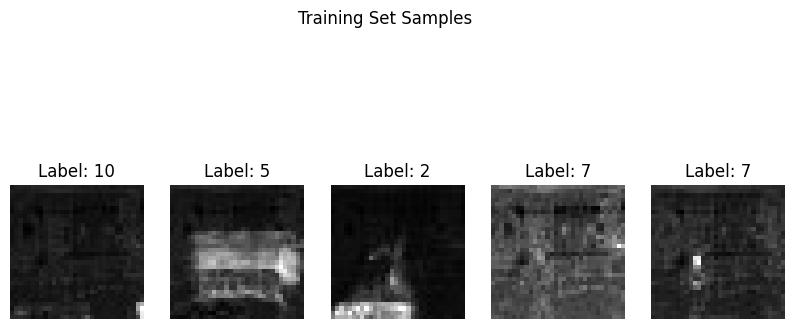

In [ ]:
# Display samples from the training set
def display_random_samples(X, y, title="Samples"):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i], cmap='gray')  # Display the summed difference image
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("Displaying samples from Training Set:")
display_random_samples(X_train, y_train, title="Training Set Samples")

In [ ]:
# Initialize model
num_classes = len(np.unique(y_train))  # Number of activity classes
input_shape = X_train.shape[1:]  # Shape of one image
model = create_model(input_shape, num_classes, image_only_flag=True)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,755 (624.04 KB)

 Trainable params: 159,755 (624.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
checkpoint_path = working_directory + "best_model_summed_diff.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train[..., np.newaxis], y_train,  # Add channel dimension for grayscale images
    #epochs=70,
    epochs=1,
    batch_size=16,
    validation_data=(X_val[..., np.newaxis], y_val),
    callbacks=[early_stopping, model_checkpoint]
)

194/194 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.2794 - loss: 1.9999 - val_accuracy: 0.5593 - val_loss: 1.3967


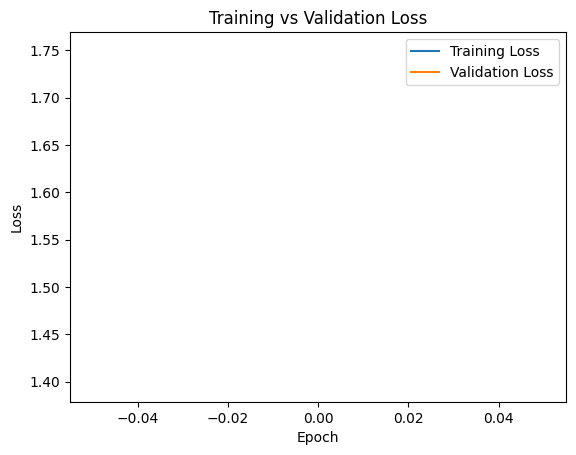

In [ ]:
# Plot Training vs. Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on Test Set
model.load_weights(checkpoint_path)
y_pred = model.predict(X_test[..., np.newaxis]).argmax(axis=1)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.00      0.00      0.00        78
           2       0.00      0.00      0.00        81
           3       0.20      0.15      0.17        79
           4       0.00      0.00      0.00        77
           5       0.94      0.99      0.97       336
           6       0.49      0.42      0.45       334
           7       0.39      0.61      0.48       335
           8       0.00      0.00      0.00        73
           9       0.68      1.00      0.81       154
          10       0.49      0.76      0.59       307

    accuracy                           0.56      1931
   macro avg       0.29      0.36      0.32      1931
weighted avg       0.46      0.56      0.49      1931



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Image + RP

In [ ]:
!rm -rf content

In [ ]:
# Load data for each trial
unzip(fused_images_zip_path, unzip_fused_images_path)

trial1_path = os.path.join(unzip_fused_images_path, "content/fused_images", "trial1_fused_images")
trial2_path = os.path.join(unzip_fused_images_path, "content/fused_images", "trial2_fused_images")
trial3_path = os.path.join(unzip_fused_images_path, "content/fused_images", "trial3_fused_images")

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test_from_trials(trial1_path, trial2_path, trial3_path)

Training data shape: (3100, 32, 32, 3) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 3) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 3) Test labels shape: (1931,)


In [ ]:
# Initialize model
num_classes = len(np.unique(y_train))  # Number of activity classes
input_shape = X_train.shape[1:]  # Shape of one image
model = create_model(input_shape, num_classes)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,331 (626.29 KB)

 Trainable params: 160,331 (626.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
checkpoint_path = working_directory + "best_model_fused_images.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    #epochs=70,
    epochs=1,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.2263 - loss: 4.7665 - val_accuracy: 0.5361 - val_loss: 1.6664


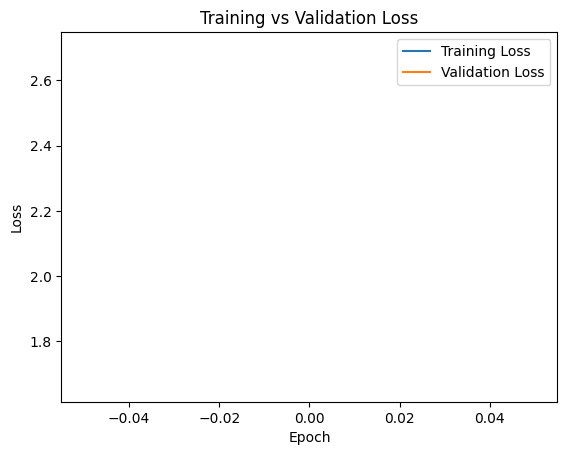

In [ ]:
# Plot Training vs. Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model
model.load_weights(checkpoint_path)

In [ ]:
# Predictions
y_pred = model.predict(X_test).argmax(axis=1)

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.00      0.00      0.00        78
           2       0.00      0.00      0.00        81
           3       0.00      0.00      0.00        79
           4       1.00      0.03      0.05        77
           5       0.79      1.00      0.88       336
           6       0.44      0.46      0.45       334
           7       0.47      0.27      0.35       335
           8       0.20      0.01      0.03        73
           9       0.70      1.00      0.82       154
          10       0.38      0.90      0.53       307

    accuracy                           0.53      1931
   macro avg       0.36      0.33      0.28      1931
weighted avg       0.46      0.53      0.44      1931

Confusion Matrix:
[[  0   0   0   0   0  19  10   3   0   0  45]
 [  0   0   0   0   0  17  14   5   0   3  39]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Using GAF + SG

In [ ]:
unzip(zip_gaf_sd_path, unzip_gaf_sd_path)
print("Dataset extracted successfully!")

# Define paths for trials
trial1_path = os.path.join(unzip_gaf_sd_path, 'fused_gaf_sd', 'trial1_fused_images')
trial2_path = os.path.join(unzip_gaf_sd_path, 'fused_gaf_sd', 'trial2_fused_images')
trial3_path = os.path.join(unzip_gaf_sd_path, 'fused_gaf_sd', 'trial3_fused_images')

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test_from_trials(trial1_path, trial2_path, trial3_path)

Dataset extracted successfully!
Training data shape: (3100, 32, 32, 3) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 3) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 3) Test labels shape: (1931,)


In [ ]:
# Get input shape and number of classes
input_shape = X_train.shape[1:]  # Assuming X_train has shape (samples, 32, 32, 3)
num_classes = len(np.unique(y_train))

# Create the model
model = create_model(input_shape, num_classes)

# Define callbacks
checkpoint_path = working_directory + "best_model_gaf_sd.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    #epochs=70,
    epochs=1,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2229 - loss: 4.6308 - val_accuracy: 0.5464 - val_loss: 1.6408


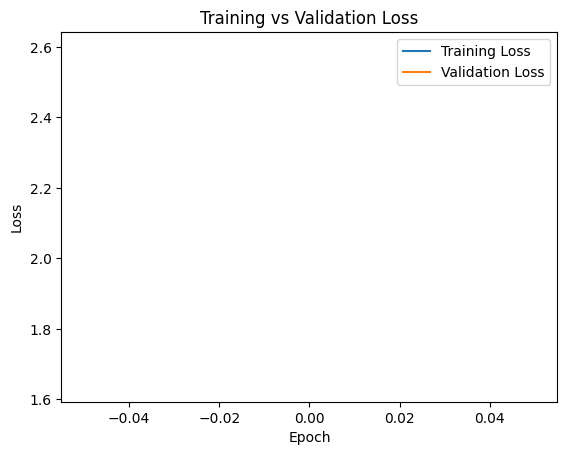

In [ ]:
# Plot Training vs. Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model
model.load_weights(checkpoint_path)

# Predict on the test set
y_pred = model.predict(X_test).argmax(axis=1)

# Classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.00      0.00      0.00        78
           2       0.00      0.00      0.00        81
           3       0.43      0.04      0.07        79
           4       0.47      0.10      0.17        77
           5       0.75      0.99      0.86       336
           6       0.50      0.49      0.49       334
           7       0.36      0.45      0.40       335
           8       0.00      0.00      0.00        73
           9       0.92      0.98      0.95       154
          10       0.41      0.74      0.53       307

    accuracy                           0.54      1931
   macro avg       0.35      0.34      0.32      1931
weighted avg       0.45      0.54      0.47      1931



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Adding more sensor data (SD + RP_ankle + RP_wrist)

In [ ]:
unzip(zip_rp_sd_ankle_wrist_path, unzip_rp_sd_ankle_wrist_path)
print("Dataset extracted.")


Dataset extracted.


In [ ]:
print(os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial1_fused_images"),)

/content/fused_images_rp_sd_ankle_wrist/fused_images_rp_sd_ankle_wrist/trial1_fused_images


In [ ]:
# Paths for each trial
trial_paths = [
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial1_fused_images"),
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial2_fused_images"),
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial3_fused_images")
]

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test_from_trials(*trial_paths)

Training data shape: (3100, 32, 32, 5) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 5) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 5) Test labels shape: (1931,)


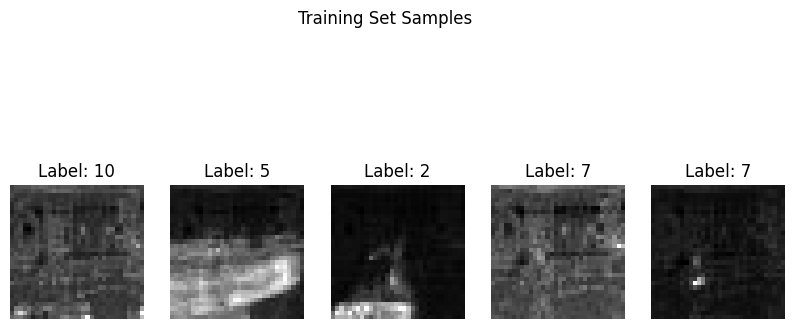

In [ ]:
# Function to display random samples
def display_random_samples(X, y, title="Samples"):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i][..., 0], cmap='gray')  # Display the first channel
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display training samples
display_random_samples(X_train, y_train, title="Training Set Samples")

In [ ]:
# Initialize model
num_classes = len(np.unique(y_train))  # Number of activity classes
input_shape = X_train.shape[1:]  # Shape of one image
model = create_model(input_shape, num_classes)

# Summary of the model
model.summary()

# Callbacks
checkpoint_path = working_directory + "best_model_rp_sd_ankle_wrist.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    X_train, y_train,
    #epochs=50,
    epochs=1,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 30, 30, 32)          │           1,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,907 (628.54 KB)

 Trainable params: 160,907 (628.54 KB)

 Non-trainable params: 0 (0.00 B)

194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.2327 - loss: 3.7020 - val_accuracy: 0.5464 - val_loss: 1.7675


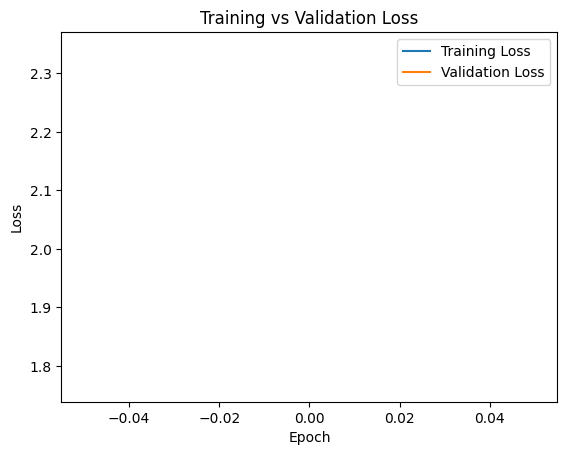

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on test set
model.load_weights(checkpoint_path)
y_pred = model.predict(X_test).argmax(axis=1)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.09      0.04      0.05        78
           2       0.00      0.00      0.00        81
           3       0.50      0.01      0.02        79
           4       0.50      0.10      0.17        77
           5       0.87      0.94      0.91       336
           6       0.39      0.78      0.52       334
           7       0.27      0.09      0.14       335
           8       1.00      0.01      0.03        73
           9       0.97      0.95      0.96       154
          10       0.42      0.81      0.55       307

    accuracy                           0.52      1931
   macro avg       0.46      0.34      0.30      1931
weighted avg       0.49      0.52      0.45      1931



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Exploring Image Averaging and Weighted Stacking techniques for the fused_images_rp_sd_ankle_wrist dataset

In [ ]:
unzip(zip_rp_sd_ankle_wrist_path, unzip_rp_sd_ankle_wrist_path)
print("Dataset extracted.")

Dataset extracted.


In [ ]:
# Paths for each trial
trial_paths = [
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist',"trial1_fused_images"),
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist',"trial2_fused_images"),
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist',"trial3_fused_images")
]

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test_from_trials(*trial_paths)

Training data shape: (3100, 32, 32, 5) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 5) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 5) Test labels shape: (1931,)


In [ ]:
def fuse_images_with_averaging(data):
    fused_data = np.mean(data, axis=-1, keepdims=True)
    return fused_data

# Apply image averaging
X_train_avg = fuse_images_with_averaging(X_train)
X_val_avg = fuse_images_with_averaging(X_val)
X_test_avg = fuse_images_with_averaging(X_test)

print(f"Averaged Training data shape: {X_train_avg.shape}")

Averaged Training data shape: (3100, 32, 32, 1)


In [ ]:
def fuse_images_with_weighted_stacking(data, weights):
    weighted_data = np.zeros_like(data[..., 0])
    for i, weight in enumerate(weights):
        weighted_data += data[..., i] * weight
    return weighted_data[..., np.newaxis]

# Define weights (adjust these as needed)
weights = [0.4, 0.3, 0.1, 0.1, 0.1]  # Example: prioritize ankle RP, wrist RP, then summed-diff

# Apply weighted stacking
X_train_weighted = fuse_images_with_weighted_stacking(X_train, weights)
X_val_weighted = fuse_images_with_weighted_stacking(X_val, weights)
X_test_weighted = fuse_images_with_weighted_stacking(X_test, weights)

print(f"Weighted Training data shape: {X_train_weighted.shape}")

Weighted Training data shape: (3100, 32, 32, 1)


In [ ]:
# Train and evaluate for a given dataset
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, checkpoint_path):
    input_shape = X_train.shape[1:]
    num_classes = len(np.unique(y_train))

    model = create_model(input_shape, num_classes)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        #epochs=50,
        epochs=1,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate
    model.load_weights(checkpoint_path)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    return history

In [ ]:
# For Image Averaging
train_and_evaluate(
    X_train_avg, y_train,
    X_val_avg, y_val,
    X_test_avg, y_test,
    working_directory + "best_model_avg.keras"
)

# For Weighted Stacking
train_and_evaluate(
    X_train_weighted, y_train,
    X_val_weighted, y_val,
    X_test_weighted, y_test,
    working_directory + "best_model_weighted.keras"
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.2424 - loss: 2.4294 - val_accuracy: 0.5593 - val_loss: 1.5479
Test Accuracy: 54.53%
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.2382 - loss: 3.0512 - val_accuracy: 0.5451 - val_loss: 1.6425
Test Accuracy: 53.65%


# Fine-tuning weights (TO BE DELETED)

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
# Function to apply weighted stacking
def fuse_images_with_weighted_stacking(data, weights):
    weighted_data = np.zeros_like(data[..., 0])
    for i, weight in enumerate(weights):
        weighted_data += data[..., i] * weight
    return weighted_data[..., np.newaxis]

In [ ]:
# Function to build and train the model
def train_and_evaluate_model(X_train_weighted, y_train, X_val_weighted, y_val, X_test_weighted, y_test):
    num_classes = len(np.unique(y_train))
    input_shape = X_train_weighted.shape[1:]

    model = create_model(num_classes=num_classes, input_shape=input_shape)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(
        X_train_weighted, y_train,
        validation_data=(X_val_weighted, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0  # Suppress detailed training logs for weight optimization
    )

    # Evaluate on the test set
    y_pred = model.predict(X_test_weighted).argmax(axis=1)
    return accuracy_score(y_test, y_pred)

In [ ]:
# Function to optimize weights
def optimize_weights(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define the objective function for weight optimization
    def objective(weights):
        X_train_weighted = fuse_images_with_weighted_stacking(X_train, weights)
        X_val_weighted = fuse_images_with_weighted_stacking(X_val, weights)
        X_test_weighted = fuse_images_with_weighted_stacking(X_test, weights)
        accuracy = train_and_evaluate_model(X_train_weighted, y_train, X_val_weighted, y_val, X_test_weighted, y_test)
        return -accuracy  # Negative because we want to maximize accuracy

    # Initial weights (equal distribution)
    initial_weights = np.ones(X_train.shape[-1]) / X_train.shape[-1]

    # Constraints: Weights should sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Bounds for weights (0 to 1)
    bounds = [(0, 1)] * X_train.shape[-1]

    # Optimize weights using minimize
    result = minimize(
        objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': True}
    )

    return result.x, -result.fun  # Return optimal weights and best accuracy

In [ ]:
# Run weight optimization
optimal_weights, best_accuracy = optimize_weights(X_train, y_train, X_val, y_val, X_test, y_test)

print(f"Optimal Weights: {optimal_weights}")
print(f"Best Accuracy Achieved: {best_accuracy:.4f}")